# ==========================================
# 1. Imports & Configuration
# ==========================================

In [1]:
import sys
from pathlib import Path

PROJECT_ROOT = Path.cwd().resolve().parent
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))


import json
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, average_precision_score,
    precision_score, recall_score, f1_score
)

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["savefig.dpi"] = 300

PROCESSED_DIR = PROJECT_ROOT / "data" / "processed"
RESULTS_DIR   = PROJECT_ROOT / "results"
MODELS_DIR    = RESULTS_DIR / "models"
FIGURES_DIR   = RESULTS_DIR / "figures"

FIGURES_DIR.mkdir(parents=True, exist_ok=True)

print(f"[✓] Project Root: {PROJECT_ROOT}")
print(f"[✓] Models Dir:   {MODELS_DIR}")
print(f"[✓] Figures Dir:  {FIGURES_DIR}")


[✓] Project Root: C:\Users\elair\Desktop\CS\cyber_bootcamp\Network-Traffic-Anomaly-Detection
[✓] Models Dir:   C:\Users\elair\Desktop\CS\cyber_bootcamp\Network-Traffic-Anomaly-Detection\results\models
[✓] Figures Dir:  C:\Users\elair\Desktop\CS\cyber_bootcamp\Network-Traffic-Anomaly-Detection\results\figures


# ==========================================
# 2. Load Trained Artifacts
# ==========================================

In [2]:
binary_pipe = joblib.load(MODELS_DIR / "binary_model.pkl")
multi_pipe  = joblib.load(MODELS_DIR / "multi_model.pkl")
multi_le    = joblib.load(MODELS_DIR / "multi_label_encoder.pkl")

with open(MODELS_DIR / "model_metadata.json", "r", encoding="utf-8") as f:
    meta = json.load(f)

BEST_THR = float(meta["binary_threshold"])

print(f"[✓] Loaded binary threshold: {BEST_THR:.6f}")
print(f"[✓] Multi classes: {list(multi_le.classes_)}")


[✓] Loaded binary threshold: 0.001010
[✓] Multi classes: ['DoS', 'Probe', 'R2L', 'U2R']


# ==========================================
# 3. Load Processed Test & Prepare X/y
# ==========================================

In [3]:
test_df = pd.read_csv(PROCESSED_DIR / "test_cleaned.csv")

# Expected label columns from notebook 02
assert "binary_target" in test_df.columns, "Missing binary_target in test_cleaned.csv"
assert "attack_class" in test_df.columns, "Missing attack_class in test_cleaned.csv"

y_test_bin = test_df["binary_target"].astype(int).values

DROP_COLS = ["label", "attack_class", "binary_target", "attack_category", "level", "id", "difficulty"]
X_test = test_df.drop(columns=DROP_COLS, errors="ignore")

print("[✓] Loaded Test:", X_test.shape, " | Attack rate:", y_test_bin.mean())


[✓] Loaded Test: (22544, 41)  | Attack rate: 0.5692423704755145


# ==========================================
# 4. Predict Probabilities Safely
# ==========================================

In [4]:
def predict_proba_best_iter(pipe, X_raw: pd.DataFrame) -> np.ndarray:
    prep  = pipe.named_steps["prep"]
    model = pipe.named_steps["model"]
    X_enc = prep.transform(X_raw)

    best_iter = getattr(model, "best_iteration", None)
    if best_iter is None:
        return model.predict_proba(X_enc)[:, 1]
    return model.predict_proba(X_enc, iteration_range=(0, best_iter + 1))[:, 1]

test_probs = predict_proba_best_iter(binary_pipe, X_test)

print("[✓] test_probs stats:",
      "mean=", float(test_probs.mean()),
      "q50=", float(np.quantile(test_probs, 0.5)),
      "q90=", float(np.quantile(test_probs, 0.9)),
      "q99=", float(np.quantile(test_probs, 0.99)))


[✓] test_probs stats: mean= 0.3799073398113251 q50= 0.01914931647479534 q90= 0.9999967813491821 q99= 0.9999998807907104


# ==========================================
# 5. Evaluation Helpers (Core Metrics + Confusion Matrix)
# ==========================================

In [5]:
def eval_binary_at_threshold(y_true, y_proba, thr: float):
    y_pred = (y_proba >= thr).astype(int)
    p = precision_score(y_true, y_pred, zero_division=0)
    r = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    pos_rate = float(y_pred.mean())

    # FPR on Normal class
    tn = np.sum((y_true == 0) & (y_pred == 0))
    fp = np.sum((y_true == 0) & (y_pred == 1))
    fpr = fp / (fp + tn + 1e-12)

    return {
        "thr": float(thr),
        "precision_attack": float(p),
        "recall_attack": float(r),
        "f1_attack": float(f1),
        "pos_rate": pos_rate,
        "fpr": float(fpr),
        "accuracy": float(np.mean(y_pred == y_true))
    }

def plot_confusion(y_true, y_pred, title: str, save_path: Path):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.savefig(save_path)
    plt.show()


# ==========================================
# 6. Baseline vs Final
# ==========================================

In [6]:
baseline_05 = eval_binary_at_threshold(y_test_bin, test_probs, 0.5)
final_best  = eval_binary_at_threshold(y_test_bin, test_probs, BEST_THR)

summary = pd.DataFrame([baseline_05, final_best], index=["Baseline(thr=0.5)", "Final(selected_thr)"])
summary

# Print clean text view
print("\n=== Baseline vs Final (TEST) ===")
for name, row in summary.iterrows():
    print(f"{name}: thr={row['thr']:.6f} | "
          f"P={row['precision_attack']:.4f} R={row['recall_attack']:.4f} "
          f"F1={row['f1_attack']:.4f} PosRate={row['pos_rate']:.4f} FPR={row['fpr']:.4f} "
          f"Acc={row['accuracy']:.4f}")



=== Baseline vs Final (TEST) ===
Baseline(thr=0.5): thr=0.500000 | P=0.9686 R=0.6303 F1=0.7636 PosRate=0.3704 FPR=0.0270 Acc=0.7779
Final(selected_thr): thr=0.001010 | P=0.8795 R=0.9439 F1=0.9106 PosRate=0.6109 FPR=0.1708 Acc=0.8945


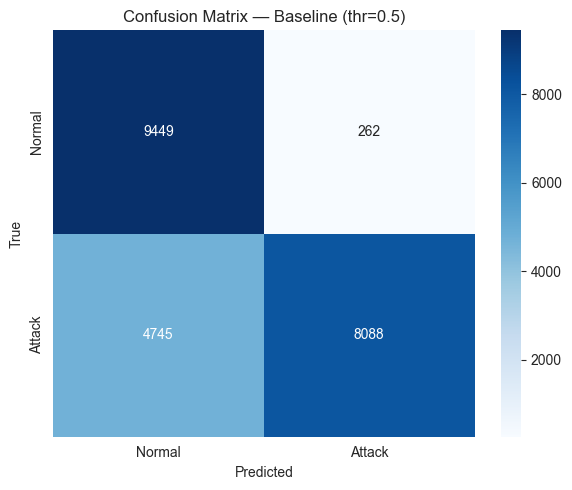

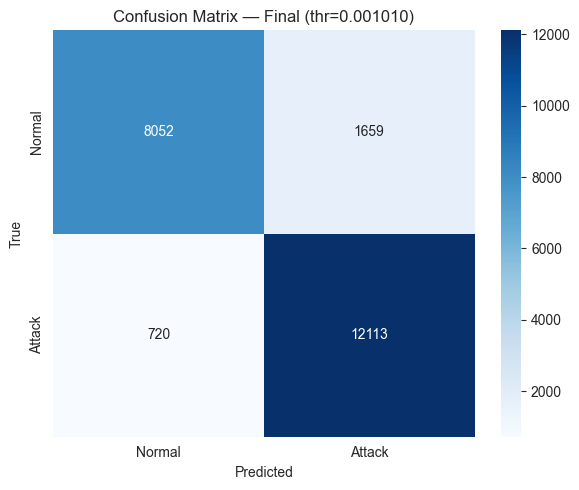

In [7]:
# Confusion matrices
y_pred_05   = (test_probs >= 0.5).astype(int)
y_pred_best = (test_probs >= BEST_THR).astype(int)

plot_confusion(y_test_bin, y_pred_05,
               "Confusion Matrix — Baseline (thr=0.5)",
               FIGURES_DIR / "cm_baseline_thr_0_5.png")

plot_confusion(y_test_bin, y_pred_best,
               f"Confusion Matrix — Final (thr={BEST_THR:.6f})",
               FIGURES_DIR / "cm_final_thr_selected.png")


# ==========================================
# 7. Threshold Sensitivity
# ==========================================

In [8]:
threshold_grid = np.linspace(0.0005, 0.02, 80)

rows = []
for thr in threshold_grid:
    rows.append(eval_binary_at_threshold(y_test_bin, test_probs, thr))

thr_df = pd.DataFrame(rows)


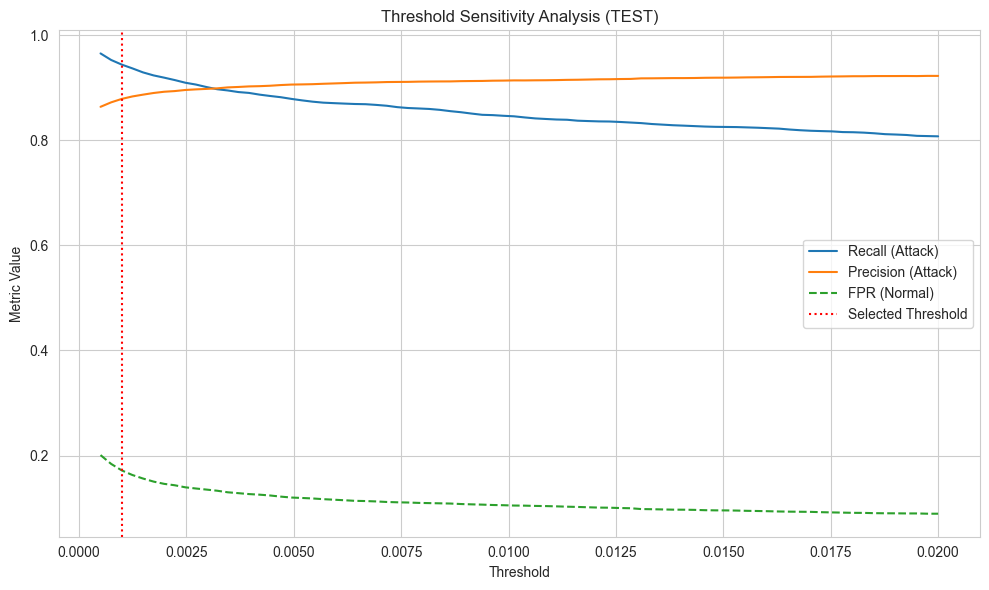

In [9]:
plt.figure(figsize=(10,6))
plt.plot(thr_df["thr"], thr_df["recall_attack"], label="Recall (Attack)")
plt.plot(thr_df["thr"], thr_df["precision_attack"], label="Precision (Attack)")
plt.plot(thr_df["thr"], thr_df["fpr"], label="FPR (Normal)", linestyle="--")

plt.axvline(BEST_THR, color="red", linestyle=":", label="Selected Threshold")

plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Threshold Sensitivity Analysis (TEST)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(FIGURES_DIR / "threshold_sensitivity.png")
plt.show()


# ==========================================
# 8. ROC & PR Curves
# ==========================================

In [10]:
from sklearn.metrics import roc_curve, precision_recall_curve

fpr, tpr, _ = roc_curve(y_test_bin, test_probs)
roc_auc = roc_auc_score(y_test_bin, test_probs)

prec, rec, _ = precision_recall_curve(y_test_bin, test_probs)
pr_auc = average_precision_score(y_test_bin, test_probs)


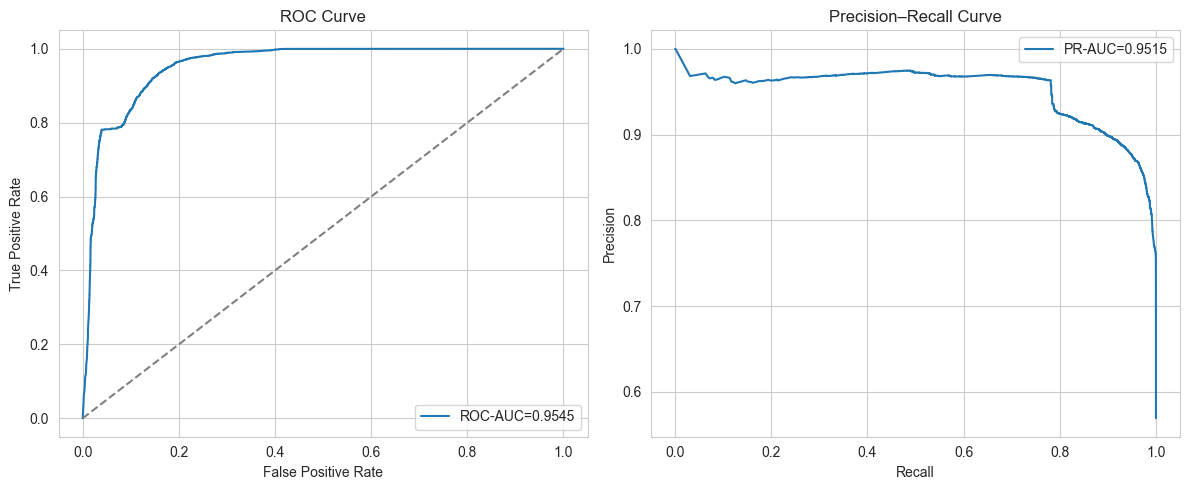

In [11]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(fpr, tpr, label=f"ROC-AUC={roc_auc:.4f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()

plt.subplot(1,2,2)
plt.plot(rec, prec, label=f"PR-AUC={pr_auc:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()

plt.tight_layout()
plt.savefig(FIGURES_DIR / "roc_pr_curves.png")
plt.show()


# ==========================================
# 9. Multi-Class Evaluation
# ==========================================

In [12]:
attack_mask = test_df["binary_target"].values == 1
X_test_attacks = X_test.loc[attack_mask]
y_test_attacks = test_df.loc[attack_mask, "attack_class"]

y_test_enc = multi_le.transform(y_test_attacks)

multi_preds = multi_pipe.predict(X_test_attacks)


In [13]:
print("=== Multi-class Classification (Attacks Only) ===")
print(classification_report(
    y_test_enc,
    multi_preds,
    target_names=multi_le.classes_,
    digits=4
))


=== Multi-class Classification (Attacks Only) ===
              precision    recall  f1-score   support

         DoS     0.9741    0.8634    0.9154      7460
       Probe     0.5216    0.9318    0.6688      2421
         R2L     0.9710    0.6031    0.7441      2885
         U2R     0.3750    0.5821    0.4561        67

    accuracy                         0.8163     12833
   macro avg     0.7104    0.7451    0.6961     12833
weighted avg     0.8849    0.8163    0.8280     12833



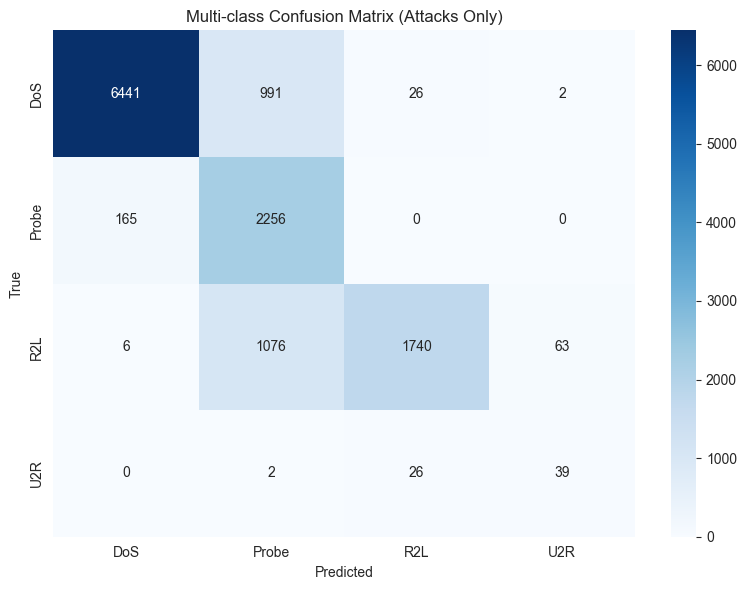

In [14]:
cm_multi = confusion_matrix(y_test_enc, multi_preds)
plt.figure(figsize=(8,6))
sns.heatmap(
    cm_multi, annot=True, fmt="d", cmap="Blues",
    xticklabels=multi_le.classes_,
    yticklabels=multi_le.classes_
)
plt.title("Multi-class Confusion Matrix (Attacks Only)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig(FIGURES_DIR / "cm_multiclass.png")
plt.show()


# ==========================================
# 1. KMeans — Analysis Only
# ==========================================

In [15]:
print("""
KMeans was used strictly for analysis:
• No labels involved
• Not used as model feature
• Fitted on train only
• Demonstrates multi-modal traffic regimes

This supports the chosen thresholding strategy
without introducing leakage or shortcuts.
""")



KMeans was used strictly for analysis:
• No labels involved
• Not used as model feature
• Fitted on train only
• Demonstrates multi-modal traffic regimes

This supports the chosen thresholding strategy
without introducing leakage or shortcuts.

